In [1]:
# https://www.kaggle.com/c/generative-dog-images/discussion/104281
# https://machinelearningmastery.com/a-gentle-introduction-to-the-biggan/
# https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/
# https://github.com/taki0112/BigGAN-Tensorflow/blob/master/BigGAN_128.py

import sys
import numpy as np
import os
import io
import cv2
import glob
import handshape_datasets as hd
import tensorflow as tf
import tensorflow_datasets as tfds
from densenet import densenet_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, ZeroPadding2D, Dense, Dropout, Activation, Reshape, Flatten
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization 
from tensorflow.keras.layers import Conv2DTranspose, LeakyReLU, Conv2D
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split

tf.__version__

'2.2.0'

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
print(tf.config.experimental.list_logical_devices('GPU'))
tf.test.is_gpu_available()


1 Physical GPUs, 1 Logical GPUs
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
# hyperparameters
# data
rotation_range = 20
width_shift_range = 0.2
height_shift_range = 0.2
horizontal_flip = True
vertical_flip = False
shear_range = 0
zoom_range = 0.2

# training
g_lr = 0.001
d_lr = 0.001
epochs = 200
max_patience = 200
min_loss = 25
min_loss_acc = 0
batch_size = 128
noise_dim = 256

# log
log_freq = 1
models_directory = 'results/models/'
date = datetime.now().strftime("%Y_%m_%d-%H:%M:%S")
identifier = "simple_gan-" + date 

In [4]:
dataset_name = 'rwth'
path = '/tf/data/{}'.format(dataset_name)
data_dir = os.path.join(path, 'data')

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
    
data = hd.load(dataset_name, Path(data_dir))

good_min = 40
good_classes = []
n_unique = len(np.unique(data[1]['y']))
for i in range(n_unique):
    images = data[0][np.equal(i, data[1]['y'])]
    if len(images) >= good_min:
        good_classes = good_classes + [i]

x = data[0][np.in1d(data[1]['y'], good_classes)]
img_shape = x[0].shape
x = tf.image.resize(x, [int(img_shape[0]/2), int(img_shape[1]/2)]).numpy()
img_shape = x[0].shape
y = data[1]['y'][np.in1d(data[1]['y'], good_classes)]
y_dict = dict(zip(np.unique(y), range(len(np.unique(y)))))
y = np.vectorize(y_dict.get)(y)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.8, test_size=0.2, stratify=y)

classes = np.unique(y_train)
n_classes = len(classes)
train_size = x_train.shape[0]
test_size = x_test.shape[0]

INFO:Loading rwth...


In [5]:
img_shape

(66, 46, 3)

In [6]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    horizontal_flip=horizontal_flip,
    vertical_flip = vertical_flip,
    shear_range=shear_range,
    zoom_range=zoom_range,
    fill_mode='constant',
    cval=0,
)

datagen.fit(x_train)

test_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
)

test_datagen.fit(x_train)

# create data generators
train_gen =  datagen.flow(x_train, y_train, batch_size=batch_size)
test_gen = test_datagen.flow(x_test, y_test , batch_size=batch_size, shuffle=False)

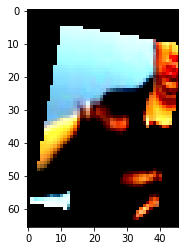

In [7]:
for images, _ in train_gen:
    plt.imshow(images[0])
    break

In [8]:
def generator_model(input_shape=(100,), output_shape=(66, 46, 3)):

    noise_input = Input(shape=input_shape, name='noise_input')
    
    x = Dense(int(output_shape[0]/2)*int(output_shape[1]/2)*32, use_bias=False, input_shape=input_shape, name='dense1')(noise_input)
    x = BatchNormalization(name='dense1_bn')(x)
    x = LeakyReLU(name='dense1_leakyrelu')(x)

    x = Reshape((int(output_shape[0]/2),int(output_shape[1]/2),32), name='reshape1')(x)

    x = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False, name='convt1')(x)
    x = BatchNormalization(name='convt1_bn')(x)
    x = LeakyReLU(name='convt1_leakyrelu')(x)

    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, name='convt2')(x)
    x = BatchNormalization(name='convt2_bn')(x)
    x = LeakyReLU(name='convt2_leakyrelu')(x)

    x = Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False, name='convt3')(x)
    x = BatchNormalization(name='convt3_bn')(x)
    x = LeakyReLU(name='convt3_leakyrelu')(x)

    output = Conv2DTranspose(output_shape[2], (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh', name='convt_out')(x)

    return Model(inputs=noise_input, outputs=output)


def discriminator_model(input_shape=(66, 46, 3)):
    img_input = Input(shape=input_shape, name='img_input')
    x = Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=input_shape, name='conv1')(img_input)
    x = LeakyReLU(name='conv1_leakyrelu')(x)
    x = Dropout(0.3, name='conv1_dropout')(x)

    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same', name='conv2')(x)
    x = LeakyReLU(name='conv2_leakyrelu')(x)
    x = Dropout(0.3, name='conv2_dropout')(x)

    x = Flatten(name='flatten')(x)
    output = Dense(1, name='out_dense')(x)

    return Model(inputs=img_input, outputs=output)

generator = generator_model(input_shape=(noise_dim,), output_shape=img_shape)
discriminator = discriminator_model(input_shape=img_shape)

In [9]:
# losses and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(g_lr)
discriminator_optimizer = tf.keras.optimizers.Adam(d_lr)

In [10]:
discriminator_loss = tf.keras.metrics.Mean(name='discriminator_loss')
generator_loss = tf.keras.metrics.Mean(name='generator_loss')

In [11]:
@tf.function
def train_step(images):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
                
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    discriminator_loss(gen_loss)
    generator_loss(disc_loss)

In [12]:
# create summary writers
train_summary_writer = tf.summary.create_file_writer('results/summaries/train/' + identifier)

In [13]:
# create a seed to visualize the progress
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

patience = 0
print("starting training")
for epoch in range(epochs):
    time_start = time.time()

    batches = 0
    for images, _ in train_gen:
        train_step(images)
        batches += 1
        if batches >= train_size / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

    time_finish = time.time()
    end_time = (time_finish-time_start)

    if (epoch % log_freq == 0):

        print ('Epoch: {}, Generator Loss: {}, Discriminator Loss: {}, Time: {} s'.format(
               epoch,
               generator_loss.result(),
               discriminator_loss.result(),
               end_time))

        if ((generator_loss.result() < min_loss) or (discriminator_loss.result() < min_loss)):    
            if not os.path.exists(models_directory):
                os.makedirs(models_directory)
            # serialize weights to HDF5
            generator.save_weights(models_directory + "best{}-generator.h5".format(identifier))
            discriminator.save_weights(models_directory + "best{}-discriminator.h5".format(identifier))
            min_loss = min(generator_loss.result(), discriminator_loss.result())
            patience = 0
        else:
            patience += 1

        generated_image = generator(seed, training=False)
        with train_summary_writer.as_default():
            tf.summary.image('generated_image', generated_image, step=epoch)
            tf.summary.scalar('generator_loss', generator_loss.result(), step=epoch)
            tf.summary.scalar('discriminator_loss', discriminator_loss.result(), step=epoch)
            generator_loss.reset_states()           
            discriminator_loss.reset_states()           

    if patience >= max_patience:
        break

starting training
Epoch: 0, Generator Loss: 0.6408173441886902, Discriminator Loss: 3.4223251342773438, Time: 6.692447900772095 s
Epoch: 1, Generator Loss: 5.663194179534912, Discriminator Loss: 11.904892921447754, Time: 2.009120225906372 s
Epoch: 2, Generator Loss: 2.646979570388794, Discriminator Loss: 34.41264343261719, Time: 2.0159895420074463 s
Epoch: 3, Generator Loss: 5.318976879119873, Discriminator Loss: 18.642471313476562, Time: 1.9747190475463867 s
Epoch: 4, Generator Loss: 1.44089937210083, Discriminator Loss: 13.051980018615723, Time: 2.017547369003296 s
Epoch: 5, Generator Loss: 0.8607137799263, Discriminator Loss: 22.026199340820312, Time: 2.021512031555176 s
Epoch: 6, Generator Loss: 0.12425529211759567, Discriminator Loss: 12.074004173278809, Time: 2.0257363319396973 s
Epoch: 7, Generator Loss: 0.06516237556934357, Discriminator Loss: 8.879050254821777, Time: 2.012329578399658 s
Epoch: 8, Generator Loss: 0.039519667625427246, Discriminator Loss: 8.351092338562012, Time

Epoch: 73, Generator Loss: 0.3677635192871094, Discriminator Loss: 6.492313385009766, Time: 2.039234161376953 s
Epoch: 74, Generator Loss: 0.3330622911453247, Discriminator Loss: 6.9561309814453125, Time: 2.074063777923584 s
Epoch: 75, Generator Loss: 0.4410649836063385, Discriminator Loss: 7.362417697906494, Time: 2.0963199138641357 s
Epoch: 76, Generator Loss: 0.2722685933113098, Discriminator Loss: 8.133783340454102, Time: 2.1024973392486572 s
Epoch: 77, Generator Loss: 0.33950573205947876, Discriminator Loss: 17.286474227905273, Time: 2.0872318744659424 s
Epoch: 78, Generator Loss: 2.8831565380096436, Discriminator Loss: 19.125118255615234, Time: 2.040855884552002 s
Epoch: 79, Generator Loss: 0.29605889320373535, Discriminator Loss: 14.853711128234863, Time: 2.0350003242492676 s
Epoch: 80, Generator Loss: 0.3202453851699829, Discriminator Loss: 16.538509368896484, Time: 1.997535228729248 s
Epoch: 81, Generator Loss: 1.3176625967025757, Discriminator Loss: 25.081369400024414, Time: 

Epoch: 145, Generator Loss: 0.05460716038942337, Discriminator Loss: 15.451957702636719, Time: 2.1000101566314697 s
Epoch: 146, Generator Loss: 0.02600259706377983, Discriminator Loss: 14.705052375793457, Time: 2.0951082706451416 s
Epoch: 147, Generator Loss: 0.017832079902291298, Discriminator Loss: 12.606193542480469, Time: 2.064513921737671 s
Epoch: 148, Generator Loss: 0.017644619569182396, Discriminator Loss: 13.217999458312988, Time: 2.1346592903137207 s
Epoch: 149, Generator Loss: 0.03499430790543556, Discriminator Loss: 12.196820259094238, Time: 2.1821746826171875 s
Epoch: 150, Generator Loss: 0.011725581251084805, Discriminator Loss: 12.507603645324707, Time: 2.1273679733276367 s
Epoch: 151, Generator Loss: 0.007529640570282936, Discriminator Loss: 11.802114486694336, Time: 2.0848770141601562 s
Epoch: 152, Generator Loss: 0.004677344113588333, Discriminator Loss: 12.352686882019043, Time: 2.113619804382324 s
Epoch: 153, Generator Loss: 0.00577980000525713, Discriminator Loss: 